### GD

The Gradient Descent is an iterative optimization technique, usually applied in ML setting, to minimize a function, which is usualy a cost function (such as MSE) by adjusting some parameters of the function

The optimization is performed by correcting the position of the current solution in the hyper-space of parameters by moving in the opposite direction of the gradient of the cost or MSE function, which is the direction of the maximum change of the function (this is way we move in the opposite direction of the gradient).

The step size in the opposite gradient direction is controlled by an hyperparameter, which is called learning rate, and it controls the magnitude of the upate. The learning rate is of paramount importance in order to ensure the convergence of the method.

This iterative approach is performed until a stopping criterion is met (either a maximum number of steps, or if a desired tolerance is met either of the residuals or between consecutive steps)

The update rule is:
$$
\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)
$$
where:
- $\theta_t$: Parameters at iteration $t$,
- $\eta$: Learning rate (step size),
- $\nabla L(\theta_t)$: Gradient of the loss function $L$ with respect to $\theta_t$.

The classical GD method is an iterative optimization (minimization/maximization) method that uses the gradient of the function as the direction (for maximization problems, the opposite direction for minimization ones) toward which to update the approximate solution: the gradient is computed by approximating its value by using the whole dataset available at each step

---

In [1]:
import numpy as np
import jax
import jax.numpy as jnp

### GD STEPS

1. Initialize parameters

In [4]:
# array with random gaussian initialization
def initialize_params(dim =2):
    np.random.seed(0)
    return np.random.randn(2)
initialize_params()

array([1.76405235, 0.40015721])

2. Define Loss Function and Gradient computation of the loss

In [3]:
def MSE(x,y,params):
    return jnp.sqrt(jnp.sum(jnp.square(y - x @ params)))
''' 
y: target
x: input 
params: learned parameters by the model
the model y_hat = X @ params is of course made by the params found
We compute the loss wrt the params found
'''


grad_jit = jax.jit(jax.grad(MSE, argnums=2)) # inform jax to compute grad wrt parameters
''' 
it will be useful when we need to compute the gradient of the loss function
at each epoch of the gradient descent itertive method
'''
MSE_jit = jax.jit(MSE) # just a compile option to speed up computatio

' \ny: target\nx: input \nparams: learned parameters by the model\nthe model y_hat = X @ params is of course made by the params found\nWe compute the loss wrt the params found\n'

3. Select Hyperparameters

In [ ]:
max_epochs = 5000
learning_rate = 0.01


4. Iterative Loop

```python
for epoch in range(max_epochs):
    grads = grad_jit(X, y, params)
    params -= learning_rate * grads

In [6]:
def gradient_descent(grad_func, x0, lr=0.01, tol=1e-6, max_iter=1000):
    x = x0
    path = [x]  # for visualization purposes only
    for _ in range(max_iter):
        grad_val = grad_func(x)
        x = x - lr * grad_val
        path.append(x)
        if jnp.linalg.norm(grad_val) < tol:
            break
    return x, path

def gradient_descent(grad_func, init_params, lr=0.01, tol=1e-6, max_iter=1000):
    params = init_params
    path = [params]  # for visualization purposes only
    for _ in range(max_iter):
        grad_val = grad_func(x)
        params = params - lr * grad_val
        path.append(params)
        if jnp.linalg.norm(grad_val) < tol:
            break
    return params, path

---

### Gradient Descent with Backtracking Line Search

Backtracking line search modifies the learning rate $ \eta $ to ensure sufficient decrease.

The key idea is to start with an initial step size and iteratively reduce it until a sufficient decrease condition is met. Specifically, the backtracking process adjusts the step size tt based on the Armijo condition:

$$
f(x - t \nabla f(x)) \leq f(x) - \alpha t \|\nabla f(x)\|^2
$$

where:

- $ f(x) $ is the objective function,
- $ \nabla f(x) $ is the gradient of $ f $ at $ x $,
- $ t $ is the step size (or learning rate) that we are adapting,
- $ \alpha \in (0, 0.5) $ is a parameter controlling the required decrease,
- $ \|\nabla f(x)\|^2 $ represents the squared norm of the gradient, quantifying how steep the descent is at $ x $.

The algorithm typically starts with an initial step size $ t = 1 $ and iteratively reduces it by multiplying it with a factor $ \beta \in (0, 1) $ (often $ \beta = 0.8 $), until the sufficient decrease condition is satisfied. The process can be summarized as follows:

1. **Initialize** $ t = 1 $.
2. **While** $ f(x - t \nabla f(x)) > f(x) - \alpha t \|\nabla f(x)\|^2 $:
   - Update $ t = \beta t $.
3. **Return** the adjusted step size $ t $.


In [7]:
def gradient_descent_backtracking(
    func, grad_func, x0, alpha=0.3, beta=0.8, tol=1e-6, max_iter=100
):
    x = x0
    path = [x]  # for visualization purposes only
    for _ in range(max_iter):
        grad_val = grad_func(x)
        t = 1.0
        # Backtracking loop
        while func(x - t * grad_val) > func(x) - alpha * t * jnp.dot(
            grad_val, grad_val
        ):
            t *= beta
        x = x - t * grad_val
        path.append(x)
        if jnp.linalg.norm(grad_val) < tol:
            break
    return x, path

---

### Exact Line Search for Quadratic Function

Exact line search minimizes the quadratic function
$$f(\boldsymbol x) = \frac{1}{2} \boldsymbol x^T A \boldsymbol x + \boldsymbol b^T \boldsymbol x + c $$
in each iteration by solving for the optimal step size $ t^* $ as:

$$
t^* = \frac{\nabla f(\boldsymbol x)^T \nabla f(\boldsymbol x)}{\nabla f(\boldsymbol x)^T A \nabla f(\boldsymbol x)}
$$

Indeed, at iteration $k$, we want to minimize the (univariate) function $g$

\begin{align*}
g(t) = f\big(\boldsymbol x^k + t \boldsymbol s^{k}\big) = \frac12 \big(\boldsymbol x^k + t \boldsymbol s^{k}\big)^T A \big(\boldsymbol x^k + t \boldsymbol s^{k}\big) + \boldsymbol b^T \big(\boldsymbol x^k + t \boldsymbol s^{k}\big) + c\\
= \frac12 \big(\boldsymbol x^k\big)^T A \boldsymbol x^k + \frac12 t ^2 \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k} + t \big( \boldsymbol s^k \big)^T A \boldsymbol x^{k} + \boldsymbol b^T \boldsymbol x^k + t \boldsymbol b^T \boldsymbol s^{k} + c \\
= f\big(\boldsymbol x^k \big) + \frac12 t ^2 \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k}+ t \big( \boldsymbol s^k \big)^T A \boldsymbol x^{k} + t \big( \boldsymbol s^{k}\big)^T \boldsymbol b\\
= f\big(\boldsymbol x^k \big) + \frac12 t ^2 \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k}+ t \big( \boldsymbol s^k \big)^T \Big[A \boldsymbol x^{k} + \boldsymbol b\Big]
\end{align*}

where $\boldsymbol s^k = -\nabla f(\boldsymbol x^k)$. Performing the derivative, we have

$$g'(t) = t \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k} + \big( \boldsymbol s^k  \big)^T \Big[A \boldsymbol x^{k} + \boldsymbol b\Big]$$

But, by definition of $f$

$$\nabla f(\boldsymbol x^k) = A \boldsymbol x^k + \boldsymbol b$$

Thus,

$$g'(t) = t \big(\boldsymbol s^{k}\big)^T A \boldsymbol s^{k} + \big( \boldsymbol s^k  \big)^T \nabla f(\boldsymbol x^k)$$

By setting $g'(t^*) = 0$ we have

$$t^* = \frac{\nabla f(\boldsymbol x^k)^T \nabla f(\boldsymbol x^k)}{\nabla f(\boldsymbol x^k)^T A \nabla f(\boldsymbol x^k)}$$


In [8]:
def exact_line_search_quadratic(A, b, x0, tol=1e-6, max_iter=100):
    x = x0
    path = [x]  # for visualization purposes only
    for _ in range(max_iter):
        grad_val = jnp.dot(A, x) + b
        t = jnp.dot(grad_val, grad_val) / jnp.dot(grad_val, jnp.dot(A, grad_val))
        x -= t * grad_val
        path.append(x)
        if jnp.linalg.norm(grad_val) < tol:
            break
    return x, path

---

### SGD

The Stochastic Gradient Descent (SGD) has been introduced to speed up the computation of the gradient of the cost/MSE function, by computing it only on a random subset of the samples, called mini-batch, instead of computing in on the whole dataset.

There are many ways to choose the subset of samples: only sample can be used, or a minibatch of the whole set (SGD with minibatch)

In Stochastic Gradient Descent (SGD), we update the parameters using the gradient computed on a random mini-batch of the data. This allows for faster convergence compared to using the full dataset at each iteration.

We will define a function to perform a single update step of SGD.

```python
# Stochastic Gradient Descent (SGD) update step
@jax.jit
def sgd_update(theta, x_batch, y_batch, learning_rate):
    grads = grad_mse_loss(theta, x_batch, y_batch)
    return theta - learning_rate * grads


```python
# Stochastic Gradient Descent with mini-batches
def stochastic_gradient_descent(
    theta,
    training_input,
    training_labels,
    validation_input,
    validation_labels,
    learning_rate=0.01,
    epochs=100,
    batch_size=10,
    state=0,
):
    key = jax.random.PRNGKey(state)
    # Iterate over the number of epochs
    for epoch in range(epochs):
        # Shuffle data indices using JAX's random key
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, len(training_input))
        # Process data in mini-batches
        for i in range(0, len(training_input), batch_size):
            batch_idx = perm[i : i + batch_size]
            x_batch = training_input[batch_idx]
            y_batch = training_labels[batch_idx]
            # Perform SGD update
            theta = sgd_update(theta, x_batch, y_batch, learning_rate)
        # Print the loss every 10 epochs
        if epoch % 10 == 0:
            loss = mse_loss(theta, validation_input, validation_labels)
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    return theta

---

## Perceptron

The **perceptron** is an algorithm for online supervised learning of binary classifiers. The algorithm tries to find a threshold function: a function that maps its input $\mathbf{x}$ (a real-valued vector) to an output value:

$$
y(\mathbf{x}) = f(\mathbf{w}^T \Phi(\mathbf{x})), \quad \text{where}
$$

$$
f(a) =
\begin{cases} 
+1, & \text{if } a \geq 0, \\
-1, & \text{if } a < 0
\end{cases}
$$

Target values are $+1$ for $C_1$ and $-1$ for $C_2$. The algorithm finds the separating hyperplane by minimizing the distance of misclassified points to the decision boundary. Our objective is to find a parameter vector $\mathbf{w}$ such that:

$$
\mathbf{w}^T \Phi(\mathbf{x}_n) \geq 0 \quad \text{when } \mathbf{x}_n \in C_1,
$$

$$
\mathbf{w}^T \Phi(\mathbf{x}_n) < 0 \quad \text{when } \mathbf{x}_n \in C_2.
$$


### Error Function

We define an error function as follows:

$$
\epsilon_p(\mathbf{w}, \mathbf{x}_n) =
\begin{cases} 
0, & \text{if } \mathbf{x} \text{ is classified correctly}, \\
\mathbf{w}^T \Phi(\mathbf{x}_n) t_n, & \text{if } \mathbf{x} \text{ is not classified correctly (proportional to boundary distance)}.
\end{cases}
$$

Now we define an error function for parameter optimization:

$$
L_P(\mathbf{w}) = - \sum_{n \in M} \mathbf{w}^T \Phi(\mathbf{x}_n) t_n
$$


### Stochastic Gradient Descent (Online)

To perform minimization, we use stochastic gradient descent:

$$
\mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \alpha \nabla L_P(\mathbf{w}) = \mathbf{w}^{(k)} + \alpha \Phi(\mathbf{x}_n) t_n
\tag{37}
$$


### Notes

**Loss Sign**:  
We have a minus sign in the loss function because $\mathbf{w}^T \Phi(\mathbf{x}_n) t_n$ will always be negative. This is due to the fact that if $\mathbf{w}^T \Phi(\mathbf{x}_n)$ is misclassified, then it will have an opposite sign compared to $t_n$.

**Learning Rate**:  
The learning rate $\alpha$ can be set to 1 because it doesn’t change the direction of $\mathbf{w}$. We assume that $\mathbf{w}$ starts from the origin, so a scaling of the vector doesn’t affect the boundary definition.


Learned weights: [ 0.52 -0.72 -0.4 ]
Errors in each epoch: [2, 4, 3, 2, 1, 0]


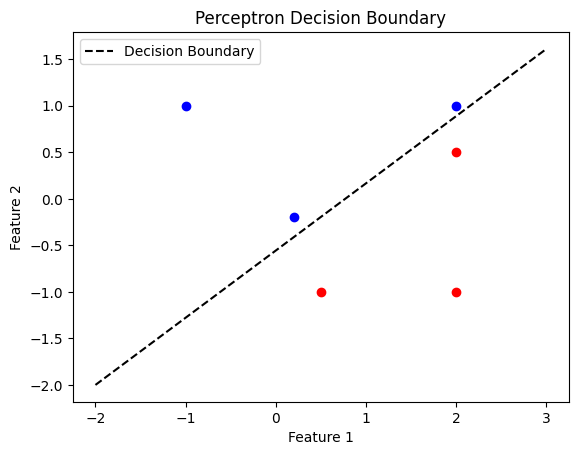

In [1]:
import numpy as np

def perceptron(X, Y, learning_rate=0.1, n_iter=1000):
    """
    Implements the perceptron algorithm.
    
    Parameters:
    - X: ndarray of shape (n_samples, n_features), input features.
    - Y: ndarray of shape (n_samples,), target labels (must be -1 or 1).
    - learning_rate: float, the step size for weight updates.
    - n_iter: int, maximum number of iterations.
    
    Returns:
    - weights: ndarray of shape (n_features,), learned weight vector.
    - errors: list, number of misclassifications in each epoch.
    """
    # Initialize weights and errors
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    errors = []
    
    for iteration in range(n_iter):
        total_errors = 0
        
        # Iterate through each sample
        for idx in range(n_samples):
            # Calculate the predicted output
            prediction = step_activation(np.dot(X[idx], weights))
            
            # Update weights if prediction is incorrect
            update = learning_rate * (Y[idx] - prediction)
            if update != 0:
                weights += update * X[idx]
                total_errors += 1
        
        # Record the number of misclassifications
        errors.append(total_errors)
        
        # Stop early if there are no errors
        if total_errors == 0:
            break
    
    return weights, errors

def step_activation(value):
    return 1 if value >= 0 else -1

# Example usage
if __name__ == "__main__":
    # Define a toy dataset
    X = np.array([[2, -1], [-1, 1], [2, 0.5], [0.2, -0.2], [0.5, -1], [2, 1]])
    Y = np.array([1, -1, 1, -1, 1, -1])  # Target labels (-1 or 1)
    
    # Add bias as the last feature
    X = np.hstack([X, np.ones((X.shape[0], 1))])  # Add a column of ones for bias

    # Train the perceptron
    learning_rate = 0.1
    n_iter = 1000
    weights, errors = perceptron(X, Y, learning_rate, n_iter)
    
    print("Learned weights:", weights)
    print("Errors in each epoch:", errors)
    
    # Visualize the decision boundary
    import matplotlib.pyplot as plt
    for i, label in enumerate(Y):
        color = 'red' if label == 1 else 'blue'
        plt.scatter(X[i, 0], X[i, 1], color=color)
    
    # Plot the decision boundary
    x_vals = np.linspace(-2, 3, 100)
    decision_boundary = -(weights[0] * x_vals + weights[-1]) / weights[1]
    plt.plot(x_vals, decision_boundary, 'k--', label="Decision Boundary")
    
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.title("Perceptron Decision Boundary")
    plt.show()
